# Linear Predictive Coding
This is a method used primarily in signal processing, especially in signal analysis, for efficiently representing a signal by estimating its future values based on its past samples. <br> 

LPC assumes that each sample in a speech signal can be approximated as a linear combination of previous samples, and the goal is to find the set of coefficients that minimizes the prediction error. This makes it an essential tool in areas like **speech compression, speech recognition, and speech analysis.**

### Key Concepts of Linear Predictive Analysis:
- Linear  Prediction
- Prediction error (Residual)
- Autocorrelation and Solving for LPC Coefficients
- Speech Model

### Example of LPC in Speech Processing: <br>
Imaging we have a recording of a person saying "hello". We can use LPC to: <br>
- Model the vocal tract by calculating the LPC coefficients.
- Transmit the coefficients instead of the full speech signal for compression.
- Reconstruct the speech on the recieving side using these coefficients and excitation signal.

By breaking down the speech into a predictive model, LPC allows efficient storage, transmission, and manipulation of speech signals.

In [9]:
# getting all the libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, find_peaks

In [10]:
# 1. Load a short speech signal
def load_audio(filename, sr=15000, duration=10):
    y, sr = librosa.load(filename, sr=sr, duration=duration)
    return y, sr

In [11]:
# 2. LPC analysis to extract LPC coefficients
def lpc(signal, order):
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order+1]
    A = np.zeros(order)
    E = np.zeros(order+1)

    E[0] = R[0] # initial error

    for i in range(1, order+1):
        k = R[i] - np.dot(A[:i-1], R[1:i][::-1])
        k /= E[i-1]
        A[i-1] = k

        if i > 1:
            A[:i-1] -= k * A[:i-1][::-1]
        
        E[i] = (1 - k**2) * E[i-1]

    return np.concatenate([[1], -A]), E[-1]

In [12]:
# 3. Reconstruct the signal using LPC coefficients
def reconstruct(lpc_coeffs, signal):
    # apply inverse filter using LPC coefficients
    reconstructed_signal = lfilter([0] + -lpc_coeffs[1:], [1], signal)
    return reconstructed_signal

In [13]:
# 4. Estimate formant frequencies from LPC coefficients
def estimate_formant(lpc_coeffs, sr):
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]

    angles = np.angle(roots)
    freqs = np.sort(angles * (sr / (2 * np.pi)))

    return freqs[:4]

In [14]:
# 5. Plotting the original signal, reconstructed signals and formants
def plot_res(original_signal, reconstructed_signal, formants, sr):
    # time axis for the signals
    t = np.arange(len(original_signal)) / sr

    plt.figure(figsize=(15,8))

    # orignal signal
    plt.subplot(2,1,1)
    plt.plot(t, original_signal, label='Original Signal')
    plt.plot(t, reconstructed_signal, label='Reconstructed Signal', alpha=0.8)
    plt.title("Original and Reconstructed Signal")
    plt.legend()

    # formants as a frequency response plot
    plt.subplot(2,1,2)
    plt.stem(formants, np.ones(len(formants)), 'r', markerfmt='ro', basefmt=" ")
    plt.title("Formants")
    plt.xlabel("Frquency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()

In [15]:
# Step 6: Main function to execute LPC analysis
def lpc_model(filename, order=12, duration=3):
    # Load audio
    signal, sr = load_audio(filename, duration=duration)
    
    # Normalize the signal
    signal = signal / np.max(np.abs(signal))
    
    # LPC analysis
    lpc_coeffs, error = lpc(signal, order)
    
    # Reconstruct signal
    reconstructed_signal = reconstruct(lpc_coeffs, signal)
    
    # Estimate formants
    formants = estimate_formant(lpc_coeffs, sr)
    
    # Print formant frequencies
    print("Estimated Formant Frequencies (Hz):", formants)
    
    # Plot results
    plot_res(signal, reconstructed_signal, formants, sr)
    
    # Return the LPC coefficients and formants for further analysis
    return lpc_coeffs, formants

Estimated Formant Frequencies (Hz): [ 236.81559566 1134.02929733 2634.24109016 4171.26470809]


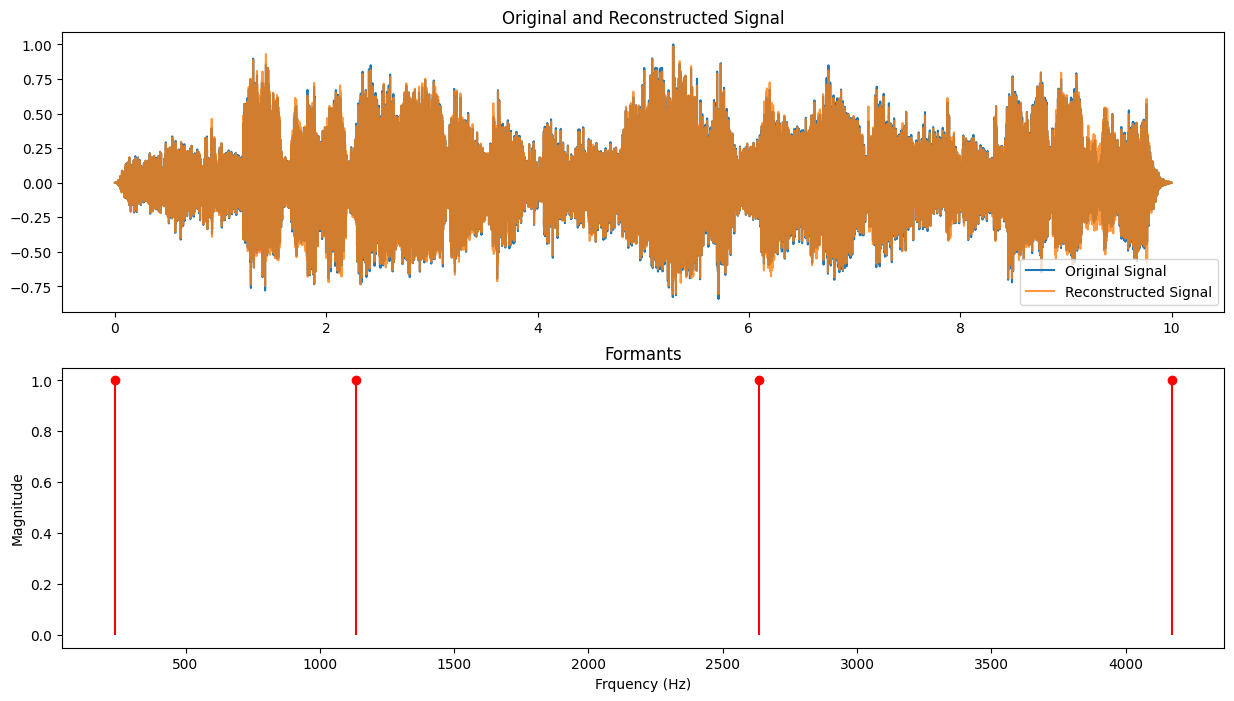

In [16]:
filename = "Jazz.wav"
lpc_coeffs, formants = lpc_model(filename, order=12, duration=10)